In [1]:
!wget -O modelnet40-normal_numpy.tar.zip https://box.skoltech.ru/index.php/s/dXgCWvAcYjgd7FC/download
!unzip modelnet40-normal_numpy.tar.zip > /dev/null
!rm modelnet40-normal_numpy.tar.zip > /dev/nully
!tar -xvf modelnet40-normal_numpy.tar > /dev/null


--2023-09-08 15:38:28--  https://box.skoltech.ru/index.php/s/dXgCWvAcYjgd7FC/download
Resolving box.skoltech.ru (box.skoltech.ru)... 195.133.216.199
Connecting to box.skoltech.ru (box.skoltech.ru)|195.133.216.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1732629450 (1.6G) [application/zip]
Saving to: ‘modelnet40-normal_numpy.tar.zip’

modelnet40-normal_n 100%[===================>]   1.61G  3.19MB/s    in 2m 50s  

2023-09-08 15:41:19 (9.73 MB/s) - ‘modelnet40-normal_numpy.tar.zip’ saved [1732629450/1732629450]



In [2]:


from torch.utils.data import DataLoader
import torch.utils.data as torch_data


from os.path import join
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.optim as optim

from tqdm import tqdm
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from IPython import display as ipython_display
import pylab as pl
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [3]:
# A data class for modelNet40 given every class iot numerical representation
# from 0 - 39
# pc - point cloud

class ModelNet(torch_data.Dataset):
    classes = {
        'airplane': 0, 'bathtub': 1, 'bed': 2, 'bench': 3,
        'bookshelf': 4, 'bottle': 5, 'bowl': 6, 'car': 7,
        'chair': 8, 'cone': 9, 'cup': 10, 'curtain': 11,
        'desk': 12, 'door': 13, 'dresser': 14, 'flower_pot': 15,
        'glass_box': 16, 'guitar': 17, 'keyboard': 18, 'lamp': 19,
        'laptop': 20, 'mantel': 21, 'monitor': 22, 'night_stand': 23,
        'person': 24, 'piano': 25, 'plant': 26, 'radio': 27,
        'range_hood': 28, 'sink': 29, 'sofa': 30, 'stairs': 31,
        'stool': 32, 'table':
        33, 'tent': 34, 'toilet': 35,
        'tv_stand': 36, 'vase': 37, 'wardrobe': 38, 'xbox': 39
    }

    def __init__(self, root, mode, n_points=1024, transform=None):
        super().__init__()
        self.root = root
        self.n_points = n_points

        self.transform = transform

        if mode == 'train':
            self.files = np.loadtxt(join(root, 'modelnet40_train.txt'), dtype=str)
        else:
            self.files = np.loadtxt(join(root, 'modelnet40_test.txt'), dtype=str)

        self.choice_idx = [np.random.choice(10000, self.n_points, replace=False) for _ in range(self.__len__())]

    def load_npy(self, f, idx):
        f = join(self.root, f)
        data = np.load(f)

        pc = data[:, :3]

        pc = pc[self.choice_idx[idx], :]

        if self.transform is not None:
            pc = self.transform(pc)

        return pc

    def __getitem__(self, idx):
        f = self.files[idx]
        cls = '_'.join(f.split('_')[:-1])

        f = '%s/%s.npy' % (cls, f)

        pc = self.load_npy(f, idx)

        return pc, self.classes[cls]

    def __len__(self):
        return len(self.files)

In [4]:
# train_data = ModelNet('./modelnet40-normal_numpy/', mode='train', n_points=2048, transform=None)
# #train_data = ModelNet('/content/modelnet40-normal_numpy/', mode='train', n_points=2048, transform=None)

# train_loader = torch_data.DataLoader(train_data, batch_size=64, shuffle=True)

In [5]:
# if we rotate a point class we have the pont cloud

class RandomJitterTransform(object):
    def __init__(self, sigma=0.01, clip=0.05):
        self.sigma = sigma
        self.clip = clip

    def __call__(self, data):
        """ Randomly jitter points. jittering is per point.
            Input:
              Nx3 array, original point clouds
            Return:
              Nx3 array, jittered point clouds
        """
        N, C = data.shape
        assert (self.clip > 0)
        jittered_data = np.clip(self.sigma * np.random.randn(N, C), -1 * self.clip, self.clip)
        print()
        jittered_data += data

        return np.float32(jittered_data)




class RandomRotateTransform(object):
    def __init__(self):
        pass

    def __call__(self, data):
        """ Randomly rotate the point clouds to augument the dataset
            rotation is per shape based along ANY direction
            Input:
              Nx3 array, original point clouds
            Return:
              Nx3 array, rotated point clouds

        """

        # generate random angle in [0, 2pi]
        rotation_angle = np.random.uniform() * 2 * np.pi



        # Create rotation matrices for each axis
        cosval = np.cos( rotation_angle)
        sinval = np.sin( rotation_angle)


        rotation_matrix_z = torch.tensor([[np.cos(rotation_angle), 0, np.sin(rotation_angle)],
                                          [0, 1, 0],
                                          [-np.sin(rotation_angle), 0, np.cos(rotation_angle)]])


        # Apply the rotations sequentially
        rotated_data = np.dot(data.reshape((-1, 3)), rotation_matrix_y)


        return np.float32(rotated_data)


class ScaleTransform(object):
    def __init__(self):
        pass

    def __call__(self, data):
        data = (data - data.min(  axis=0)) / (data.max(axis=0) - data.min(axis=0))
        return np.float32(data)

In [12]:
def get_model_net_40(datadir, batch_size, num_points):
   # transforms.Compose is a pytorch class for composing serveral tfm
    transform = transforms.Compose([
        RandomRotateTransform(),
        RandomJitterTransform(),
        ScaleTransform(),
    ])

    train_data = ModelNet(datadir, mode='train', n_points=num_points, transform=transform)
    test_data = ModelNet(datadir, mode='test', n_points=num_points, transform=transform)

    train_loader = torch_data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = torch_data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

    return train_loader, test_loader

In [13]:
train_loader, test_loader = get_model_net_40('./modelnet40-normal_numpy/', batch_size=64, num_points=2048)

len(train_loader), len(test_loader)

(154, 39)

In [19]:
class TNet(nn.Module):
    def __init__(self, dim, num_points=2048):
        super().__init__()
        self.dim = dim
        self.conv1 = torch.nn.Conv1d(dim, 64, 1)
        self.bn1 = nn.BatchNorm1d(64)

        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.bn2 = nn.BatchNorm1d(128)

        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.bn3 = nn.BatchNorm1d(1024)

        self.fc1 = nn.Linear(1024, 512)
        self.bn4 = nn.BatchNorm1d(512)

        self.fc2 = nn.Linear(512, 256)
        self.bn5 = nn.BatchNorm1d(256)

        self.fc3 = nn.Linear(256, dim*3)
        self.relu = nn.ReLU()



        self.max_pool = nn.MaxPool1d(kernel_size=num_points)


    def forward(self, x):
        bs = x.size()[0]

        x = x.transpose(2, 1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))

        x = self.max_pool(x)
        x = x.view(-1, 1024)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)



        # initialize identity matrix
        iden = torch.eye(self.dim, requires_grad=True).repeat(bs, 1, 1)
        if x.is_cuda:
            iden = iden.cuda()

        x = x.view(-1, self.dim, self.dim) + iden


        return x


class PointNet(nn.Module):
    def __init__(self, num_classes=40, num_points=2048, use_dropout = True):
        super().__init__()
        self.tnet = TNet(3)
        self.use_dropout = use_dropout
        self.num_classes = num_classes

        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.bn1 = torch.nn.BatchNorm1d(64)
        if self.use_dropout:
          self.dropout1d = nn.Dropout(p=0.1)


        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.bn2 = torch.nn.BatchNorm1d(128)
        if self.use_dropout:
          self.dropout2d = nn.Dropout(p=0.2)

        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.bn3 = torch.nn.BatchNorm1d(1024)
        if self.use_dropout:
          self.dropout3d = nn.Dropout(p=0.3)

        self.max_pool = nn.MaxPool1d(kernel_size=num_points)





        self.general_part = nn.Sequential(
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Linear(256, self.num_classes),
            nn.Softmax()
        )




    def forward(self, x):
        trans = self.tnet(x)
        x = torch.bmm(x, trans)
        bs = x.size()[0]
        x = x.transpose(2, 1)

        x = F.relu(self.bn1(self.conv1(x)))

        if self.use_dropout:
          x = self.dropout1d(x)

        x = F.relu(self.bn2(self.conv2(x)))
        if self.use_dropout:
          x = self.dropout2d(x)

        x = self.bn3(self.conv3(x))
        if self.use_dropout:
          x = self.dropout1d(x)

        # x, _ = torch.max(x, 2)

        #x = self.max_pool(x).view(bs, -1)
        x = self.max_pool(x)
        x = x.view(-1, 1024)

        x = self.general_part(x)

        return x

# # Create an instance of the PointNet model with enhancements
# num_classes= 40  # For ModelNet-10
# batchsize = 64
# pointnet = PointNet(num_classes)

# # Define your loss function (e.g., Cross-Entropy)
# criterion = nn.CrossEntropyLoss()

# # Define your optimizer (e.g., Adam)
# optimizer = optim.Adam(pointnet.parameters(), lr=0.001)

# # Training loop
# num_epochs = 10
# for epoch in range(num_epochs):
#     for batch in train_loader:
#         inputs, labels = batch
#         optimizer.zero_grad()
#         outputs = pointnet(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

# # Save the trained PointNet model if needed
# torch.save(pointnet.state_dict(), 'pointnet_modelnet40.pth')





In [20]:

def eval_net(net, test_loader, epoch_i):
    net = net.eval()

    acc = 0
    n_pc = 0

    for batch_it, (x_tr, y_tr) in enumerate(test_loader):

        x_input = torch.FloatTensor(x_tr).cuda()
        y_input = torch.LongTensor(y_tr).cuda()

        probs = net(x_input)

        acc += (probs.data.cpu().argmax(dim=1) == y_tr).sum()
        n_pc += y_tr.shape[0]

    acc = float(acc.data.cpu().numpy()) / n_pc

    print('Test accuracy: %.2f' % acc)

def train_net(net, n_epochs, train_loader, test_loader):
    loss_func = torch.nn.CrossEntropyLoss()
    minimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

    losses = []

    for epoch_i in range(10):
        print('EPOCH %s' % epoch_i)
        with torch.no_grad():
          eval_net(net, test_loader, epoch_i)
        net = net.train()

        acc = 0
        n_pc = 0

        for batch_it, (x_tr, y_tr) in enumerate(train_loader):
            x_input = torch.FloatTensor(x_tr).cuda()
            y_input = torch.LongTensor(y_tr).cuda()

            probs = net(x_input)

            # print(y_input, probs)
            loss = loss_func(probs, y_input).mean()

            minimizer.zero_grad()
            loss.backward()
            minimizer.step()

            acc += (probs.data.cpu().argmax(dim=1) == y_tr).sum()
            n_pc += y_tr.shape[0]

            losses.append(loss.item())

        ipython_display.display(pl.gcf())
        ipython_display.clear_output(wait=True)
        plt.title('Loss')
        print(losses)
        plt.plot(losses)
        plt.show()



In [21]:
net = PointNet().cuda()

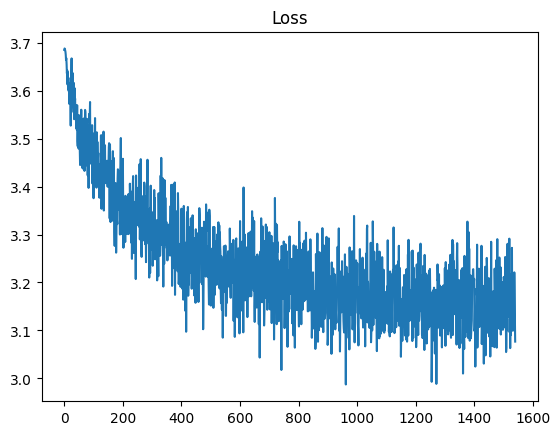

In [22]:
train_net(net.cuda(), 10, train_loader, test_loader)